#VISUALISATIE 2 NETWERK GUIDO GEZELLE

##INTRO

Dit is een voorbeeld van een netwerkvisualisatie omtrent Guido Gezelle met beschikbare data op Wikidata. Deze visualisatie gaat dieper in op de relatie tussen correspondenten. Deze visualisatie vormt de tweede van meerdere visualisaties omtrent Guido Gezelle op Wikidata. Wat volgt, is een handleiding om deze visualisatie te creeëren.

##VRAAG

Welke personen die brieven hebben gestuurd of ontvangen van Guido Gezelle, hebben ook met elkaar gecorrespondeerd? Welke correspondenten zijn ook familie van elkaar? Met extra attributen voor eigenschappen zoals geslacht, geboorteplaats, geboortejaar, enz.

mogelijk alternatief bij weinig resultaten: Welke personen zijn gekoppeld aan Guide Gezelle, of waaraan Guido Gezelle gekoppeld is, zijn ook aan elkaar gerelateerd? En wat is die relatie? Geef van deze personen extra attributen voor eigenschappen zoals werkplaats, geslacht, geboorteplaats, geboortejaar enz.

##QUERIES

Om deze vragen te beantwoorden, zullen we gebruik maken van de informatie die beschikbaar is op Wikidata omtrent Guido Gezelle. Op Wikidata is veel informatie verzameld en volgens een specifiek relationeel model gestructureerd. Zo kan data eenvoudig aan elkaar gelinkt worden en in relatie tot elkaar opgevraagd worden. Hiervoor gebruiken we de Wikidata Query Service. Via deze service is het mogelijk om queries te ontwerpen op basis van codetaal. De codetaal die hiervoor gebruikt wordt, is SPARQL. Over deze codetaal is veel documentatie terug te vinden. Hieronder hebben we enkele queries opgesteld met behulp van deze service. Daarnaast hebben we ook gebruik gemaakt van generatieve AI, in dit geval Gemini om de queries te stroomlijnen of wat tijd uit te sparen bij het testen van enkele varianten.

Opmerking: de rekencapaciteit van Wikidata Query Service is snel overbelast. Queries mogen dus niet te uitgebreid of complex zijn. Dit zorgt voor server overload. Om die reden worden in deze voorbeelden de vraagstelling opgedeeld in verschillende deelvragen, die elk met een simpele query beantwoord kunnen worden.

In wat volgt, gebruiken we drie queries. De eerste query geeft alle correspondenten van Guido weer, alsook bij wie Guido de correspondent is. Daarbij worden geslacht, geboortedatum, geboorteplaats en afbeelding opgehaald. De twee andere queries horen eigenlijk samen maar door beperkte rekenkracht van Wikidata query service hebben we ze opgedeeld. De tweede query geeft alle correspondenten die ook onderling met elkaar communiceerd hebben. De derde query geeft ook de gedeelde familerelaties van deze personen weer.

###Query1

In [ ]:
# Visualisatie 2 Query 1 : Alle correspondenten van Gezelle + Attributen (Nodes)
# defaultView:Table
SELECT DISTINCT ?person ?personLabel
       ?geslachtLabel ?geboortejaar ?geboorteplaatsLabel ?imageLink
WHERE {
  BIND(wd:Q336977 AS ?guido)

  #  Vind alle correspondenten
  {
    ?guido p:P3342 ?stmt.
    ?stmt ps:P3342 ?person.
    ?stmt pq:P3831 wd:Q3589290. # Rol = correspondent
  } UNION {
    ?person p:P3342 ?stmt.
    ?stmt ps:P3342 ?guido.
    ?stmt pq:P3831 wd:Q3589290. # Rol = correspondent
  }
  FILTER(?person != ?guido) # Verwijder Gezelle zelf uit de lijst

  # Extra attributen ophalen
  OPTIONAL { ?person wdt:P21 ?geslacht. }
  OPTIONAL {
    ?person wdt:P569 ?geboortedatumValue.
    BIND(YEAR(?geboortedatumValue) AS ?geboortejaar)
  }
  OPTIONAL { ?person wdt:P19 ?geboorteplaats. } # Geboorteplaats
  OPTIONAL { ?person wdt:P18  ?imageLink } # afbeelding

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?person rdfs:label ?personLabel.
    ?geslacht rdfs:label ?geslachtLabel.
    ?geboorteplaats rdfs:label ?geboorteplaatsLabel.
  }
}
LIMIT 10000

###Query2

In [ ]:
# Visualisatie 2 Query 2: Correspondentie Relatie (edge)
# defaultView:Table
SELECT DISTINCT ?Source ?Target ?Label ?imageLink
WHERE {

  # Subquery: Definieer de "Pool" van Gezelle's correspondenten (nodig om de query klein te houden)
  { SELECT ?personA WHERE { BIND(wd:Q336977 AS ?guido) { ?guido p:P3342 ?stmt. ?stmt ps:P3342 ?personA. ?stmt pq:P3831 wd:Q3589290. } UNION { ?personA p:P3342 ?stmt. ?stmt ps:P3342 ?guido. ?stmt pq:P3831 wd:Q3589290. } FILTER(?personA != ?guido) } }
  { SELECT ?personB WHERE { BIND(wd:Q336977 AS ?guido) { ?guido p:P3342 ?stmt. ?stmt ps:P3342 ?personB. ?stmt pq:P3831 wd:Q3589290. } UNION { ?personB p:P3342 ?stmt. ?stmt ps:P3342 ?guido. ?stmt pq:P3831 wd:Q3589290. } FILTER(?personB != ?guido) } }

  FILTER(STR(?personA) < STR(?personB)) # Zorgt ervoor dat elke link maar één keer voorkomt

  # VIND DE CORRESPONDENTIE RELATIE TUSSEN A EN B
  {
    ?personA p:P3342 ?stmtC. ?stmtC ps:P3342 ?personB. ?stmtC pq:P3831 wd:Q3589290.
  } UNION {
    ?personB p:P3342 ?stmtC. ?stmtC ps:P3342 ?personA. ?stmtC pq:P3831 wd:Q3589290.
  }

  # BINDING voor Gephi kolomnamen
  BIND(?personA AS ?Source)
  BIND(?personB AS ?Target)
  BIND("heeft als correspondent" AS ?Label)
}
LIMIT 10000

###Query3

In [ ]:
# Visualisatie 2 Query 3: Familie Relaties tussen ALLE correspondenten (edge)
# Gebruikt STR() om de output te strippen van de lange URL's.
# defaultView:Table
SELECT DISTINCT ?personA ?personB ?relatieTypeLabel
WHERE {
  BIND(wd:Q336977 AS ?guido) # Guido Gezelle
  BIND(wd:Q3589290 AS ?CorrespondentRole) # Rol: correspondent

  # --- 1. DEFINITIE POOL A: Persoon A is correspondent (beide richtingen) ---
  {
    # Guido is de bron OF Guido is het doel
    { ?guido p:P3342 ?stmtA. ?stmtA ps:P3342 ?personA. ?stmtA pq:P3831 ?CorrespondentRole. } UNION
    { ?personA p:P3342 ?stmtA. ?stmtA ps:P3342 ?guido. ?stmtA pq:P3831 ?CorrespondentRole. }
  }

  # --- 2. DEFINITIE POOL B: Persoon B is correspondent (beide richtingen) ---
  {
    # Guido is de bron OF Guido is het doel
    { ?guido p:P3342 ?stmtB. ?stmtB ps:P3342 ?personB. ?stmtB pq:P3831 ?CorrespondentRole. } UNION
    { ?personB p:P3342 ?stmtB. ?stmtB ps:P3342 ?guido. ?stmtB pq:P3831 ?CorrespondentRole. }
  }

  # --- 3. Filters ---
  FILTER(STR(?personA) < STR(?personB)) # Zorgt voor unieke, ongerichte edges
  FILTER(?personA != ?guido)
  FILTER(?personB != ?guido)

  # --- 4. VIND RELATIE: Familie-eigenschappen ---
  VALUES ?famProp { wdt:P22 wdt:P25 wdt:P26 wdt:P40 wdt:P3373 }
  { ?personA ?famProp ?personB. } UNION { ?personB ?famProp ?personA. }

  # --- 5. VRAAG HET LABEL VAN DE PROPERTY OP ---
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?famProp rdfs:label ?relatieTypeLabel.
  }

}
LIMIT 3500

Volgende queries worden momenteel niet gebruikt, maar leken interessant. Het probleem zit vooral in dat meerdere onderwijsinstellingen aan een persoon gekoppeld kunnen zijn. Dit maakt het moeilijk deze te visualiseren, omdat deze cellen samengevoegd horen te worden of er anders maar een waarde geselecteerd kan worden voor visualisatie. Beide scenarios vormen geen goede basis voor zinvolle/correcte visualisaties.

###Query4-5: niet gebruikt!

In [ ]:
# Visualisatie 2 Query 4A: Gedeelde Onderwijsinstelling (wdt:P69) - Persoon is correspondent (edge)
# Gebruikt de directe 'wdt' notatie. Werkt alleen als de data simpel is.
# defaultView:Table
SELECT DISTINCT ?personA ?personB ?schoolLabel
WHERE {
  BIND(wd:Q336977 AS ?guido) # Guido Gezelle
  BIND(wd:Q3589290 AS ?CorrespondentRole) # Rol: correspondent

  # --- 1. DEFINITIE POOL A: Persoon A is correspondent (beide richtingen) ---
  {
    # Gelinkt aan Guido Gezelle
    { ?guido p:P3342 ?stmtA. ?stmtA ps:P3342 ?personA. ?stmtA pq:P3831 ?CorrespondentRole. }
   }

  # --- 2. DEFINITIE POOL B: Persoon B is correspondent (beide richtingen) ---
  {
    # Gelinkt aan Guido Gezelle
    { ?guido p:P3342 ?stmtB. ?stmtB ps:P3342 ?personB. ?stmtB pq:P3831 ?CorrespondentRole. }
  }

  # --- 3. Filters ---
  FILTER(STR(?personA) < STR(?personB)) # Zorgt voor unieke, ongerichte edges
  FILTER(?personA != ?guido)
  FILTER(?personB != ?guido)

  # VIND RELATIE: Gedeelde Onderwijsinstelling (wdt:P69)
  # Zoekt naar de meest simpele, directe triple-relatie

  ?personA wdt:P69 ?school.
  ?personB wdt:P69 ?school.

  # --- 5. VRAAG HET LABEL VAN DE GEDEELDE SCHOOL OP ---
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?school rdfs:label ?schoolLabel.
  }
}
LIMIT 10000

In [ ]:
# Visualisatie 2 Query 4B: Gedeelde Onderwijsinstelling (wdt:P69) -  Guido is Correspondent (edge)
# Gebruikt de directe 'wdt' notatie. Werkt alleen als de data simpel is.
# defaultView:Table
SELECT DISTINCT ?personA ?personB ?schoolLabel
WHERE {
  BIND(wd:Q336977 AS ?guido) # Guido Gezelle
  BIND(wd:Q3589290 AS ?CorrespondentRole) # Rol: correspondent

  # --- 1. DEFINITIE POOL A: Guido is Correspondent ---
  {
    # Guido Gezelle Gelinkt aan persoon
    { ?personA p:P3342 ?stmtA. ?stmtA ps:P3342 ?guido. ?stmtA pq:P3831 ?CorrespondentRole. }
   }

  # --- 2. DEFINITIE POOL B: Guido is correspondent ---
  {
    # Guido Gezelle Gelinkt aan persoon
    { ?personB p:P3342 ?stmtB. ?stmtB ps:P3342 ?guido. ?stmtB pq:P3831 ?CorrespondentRole. }
  }

  # --- 3. Filters ---
  FILTER(STR(?personA) < STR(?personB)) # Zorgt voor unieke, ongerichte edges
  FILTER(?personA != ?guido)
  FILTER(?personB != ?guido)

  # VIND RELATIE: Gedeelde Onderwijsinstelling (wdt:P69)
  # Zoekt naar de meest simpele, directe triple-relatie

  ?personA wdt:P69 ?school.
  ?personB wdt:P69 ?school.

  # --- 5. VRAAG HET LABEL VAN DE GEDEELDE SCHOOL OP ---
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?school rdfs:label ?schoolLabel.
  }
}
LIMIT 10000

Nogmaals, we gebruiken enkel query 1 tot en met 3 voor de verdere visualisatie.

##EXPORT

Vervolgens moet de data gedownload worden en verder worden verwerkt in software zoals Spreadsheets, Excel, OpenRefine, enzvoort. Hier is het doel om een bestand met knopen en een bestand met verbindingen te maken, aangezien dat de twee bouwstenen van de visualisatie worden. Eerst en vooral exporteren we alle resultaten van de queries als afzonderlijke bestanden en geven ze een duidelijke naam 'RawV2Q1', 'RawV2Q2 en 'RawV2Q3'.

In google spreadsheets worden de gegevens verder bewerkt. Er worden twee bestanden opgemaakt. Het eerste bestand bevat alle knooppunten (nodes), het tweede bestanden alle verbindingen (edges). Hieronder worden daarvoor alle stappen doorlopen. Open Spreadsheets of Excel en importeer één voor één de verschillende gedownloade bestanden met de resultaten van de queries, elk afzonderlijk als nieuw tabblad in hetzelfde spreadsheet-project. Noem de tabbladen 'RawV2Q1', 'RawV2Q2', enzovoort.

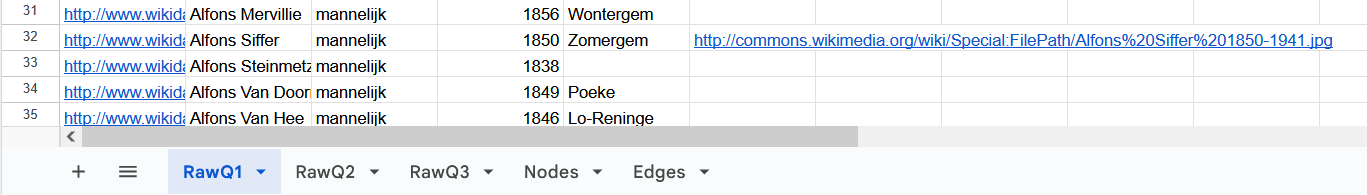

##NODES

Dit document zal alle knopen bevatten van onze visualisatie.

1. In dit geval is het vrij eenvoudig. maak een duplicaat van de resultaten van de eerste query, in dit geval 'RawV2Q1'. Dit zijn de kolommen: person,personLabel,geslachtLabel,geboortejaar,geboorteplaatsLabel, imageLink.

2. Hernoem de eerste 2 kolommen respectievelijk naar 'ID', 'Label'. Zo kan Gephi ze herkennen bij het inladen.

3. Voeg een nieuwe (lege) kolom in na de eerste twee en noem deze 'Type'. Hier kun je voorlopig 'person' ingeven voor alle cellen. Je kan echter ook opteren om hier het type relatie te plaatsen zoals bijvoorbeeld familie of correspondent, of meer specifiek welke soort familie. Deze gegevens zijn te halen uit de andere queries. Hier is dit niet zo belangrijk.

4. De andere kolommen zijn vrij te benoemen. Kies een logische naam. In dit geval krijgen we dan alles samen deze kolommen. ID,Label,Type,Gender,Year of Birth,Place of Birth, Image Link

5. Wikidata URL's verwijderen in de Id-kolom: Gephi kan enkel werken met de Q-nummers, niet met links. Dit kan eenvoudig opgelost worden door de kolom met de links te selecteren en dan in het hoofdmenu (bovenaan) te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

6. opvullen lege cellen: filter instellen, op icoontje in top van kolom klikken en enkel de lege cellen selecteren. Vervolgens in een van deze cellen 'gegevens onbekend' of iets dergelijks ingeven en naar beneden slepen.

7. duplicaten verwijderen: knopen mogen maar een keer voorkomen in de visualisatie. Daarom is het belangrijk alle dubbels te verwijderen. Dat kan door in het hoofdmenu naar in het hoofdmenu te klikken op 'gegevens' - 'gegevens opschonen' - 'duplicaten verwijderen'. Let erop dat je alle kolommen selecteert.

8. Vervolgens kun je de tab de naam 'nodes' geven, indien dit nog niet is gebeurd. Via exporteren of downloaden kun je kiezen om het csv-bestand te downloaden.

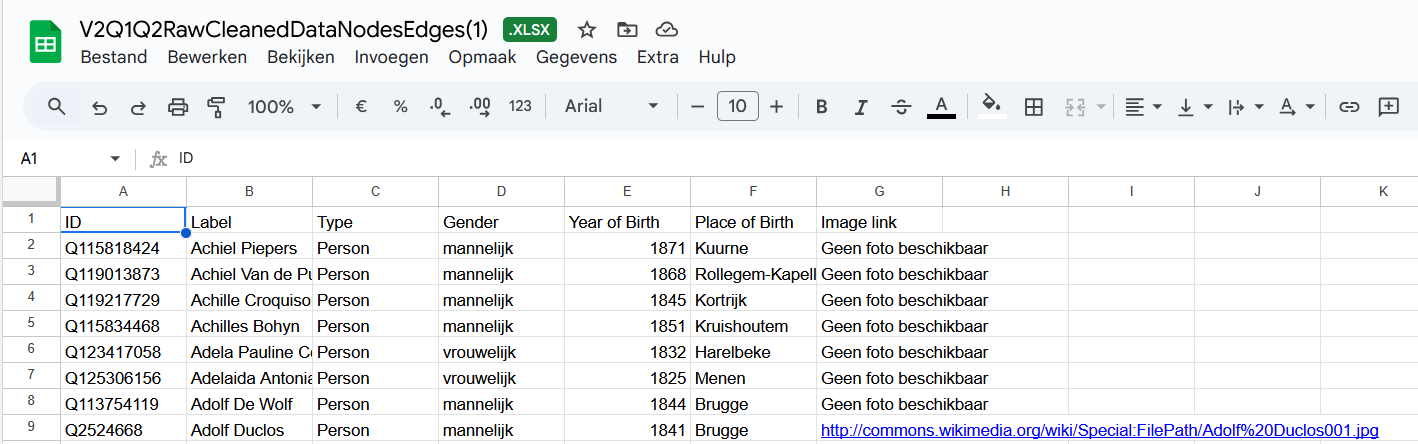

##EDGES

dit bestand beschrijft alle verbindingen tussen de knopen.

1. Om te beginnen kun je een nieuw tabblad aanmaken en het de naam 'edges' geven. Hierin kan je RawV2Q2 en RawV2Q3 onder elkaar plakken. Plaats de labels van de kolommen enkel bovenaan. Geef deze drie kolommen vervolgens de namen 'source','target' en 'label'.

2. kolom label fixen: omdat onze querie geen namen weergeeft, maar enkel de nummer van de P-relatie, zullen we deze data handmatig omzetten naar de juiste labels; Het zijn toch maar enkele om aan te passen. Hieronder lijst:

P69
P108
P463

3. Voeg vervolgens nog drie kolommen toe met de naam 'Type', 'Weight' en RelationType. De kolom 'Type' mag opgevuld worden met 'directed'. opmerking: natuurlijk zijn er ook 'undirected'-relaties (zoals broer/zus, partner), maar daar houden we nu even geen rekening mee. Vul een celwaarde in en sleep dan de hele kolom naar beneden. Bij 'Weight' mag op dezelfde manier overal '1' ingevuld worden.

4. Tot slot hebben kun je de extra kolom 'RelationType' toevoegen. Deze is optioneel, maar zal in dit geval het soort relatie in twee groepen opdelen: familie en correspondent. Om dit te doen plaatsen we 'correspondentie' bij alle correspondenten (af te lezen uit kolom Label). Bij alle familieverbanden (tweede helft van de data in deze kolom) plaatsen we bij elk specifiek familieverband (opnieuw af te lezen in kolom Label) 'familieverband' in de kolom 'RelationType'.

5. Vervolgens zetten we de wikidata-links om in enkel Q-nummers door kolom te selecteren en vervolgens via het hoofdmenu 'bewerken' te kiezen en vervolgens 'zoeken en vervangen' te selecteren. we vervangen 'http://www.wikidata.org/entity/' door '' (leeg) en drukken op 'vervangen'. Vervolgens selecteren we de ganse kolom, kopieren en plakken ze op dezelfde plaats en kiezen in het submenu voor 'alleen waarden plakken'. Zo blijven enkel de Q-nummers over. Dit is belangrijk voor Gephi.



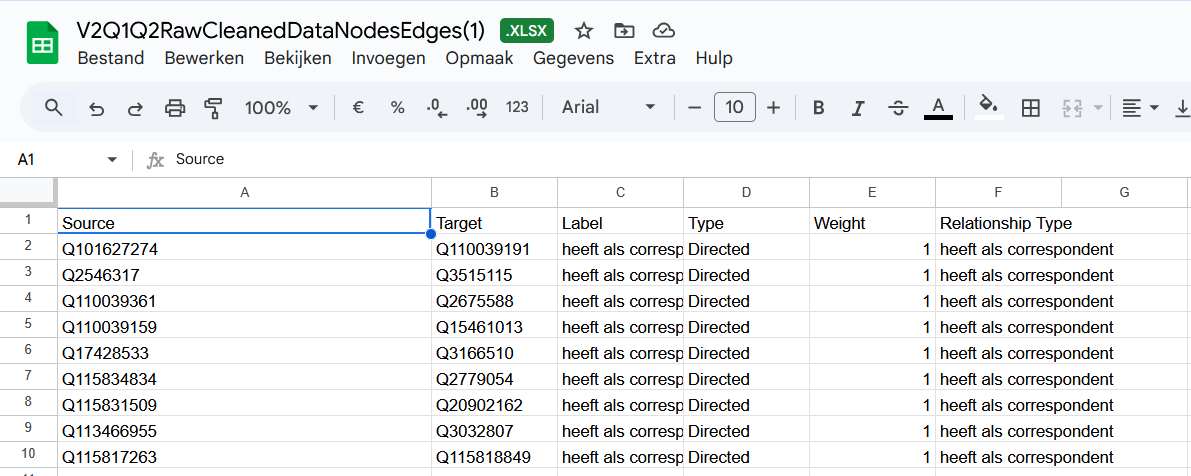

##GEPHI

In Gephi kunnen beide documenten (nodes en edges) opgeladen worden om een netwerkvisualisatie te bekomen. Hieronder wordt toegelicht hoe dat te doen.

Eerst laden we de nodes.csv in. Vervolgens laden we de edges.csv in hetzelfde spreadsheet in Gephi. Open Gephi en start een nieuw project. Vervolgens laden we eerst de node file in. Via 'file' en dan 'import spreadsheet' kunnen de documenten worden ingeladen. Selecteer het bestand en kies bij het menu 'import as' voor 'node table'. Klik een paar keer op 'next' en kies ervoor om de data op het huidige tabblad in te laden. Doe hetzelfde voor de edges-file, maar kies dan voor 'edges table'.



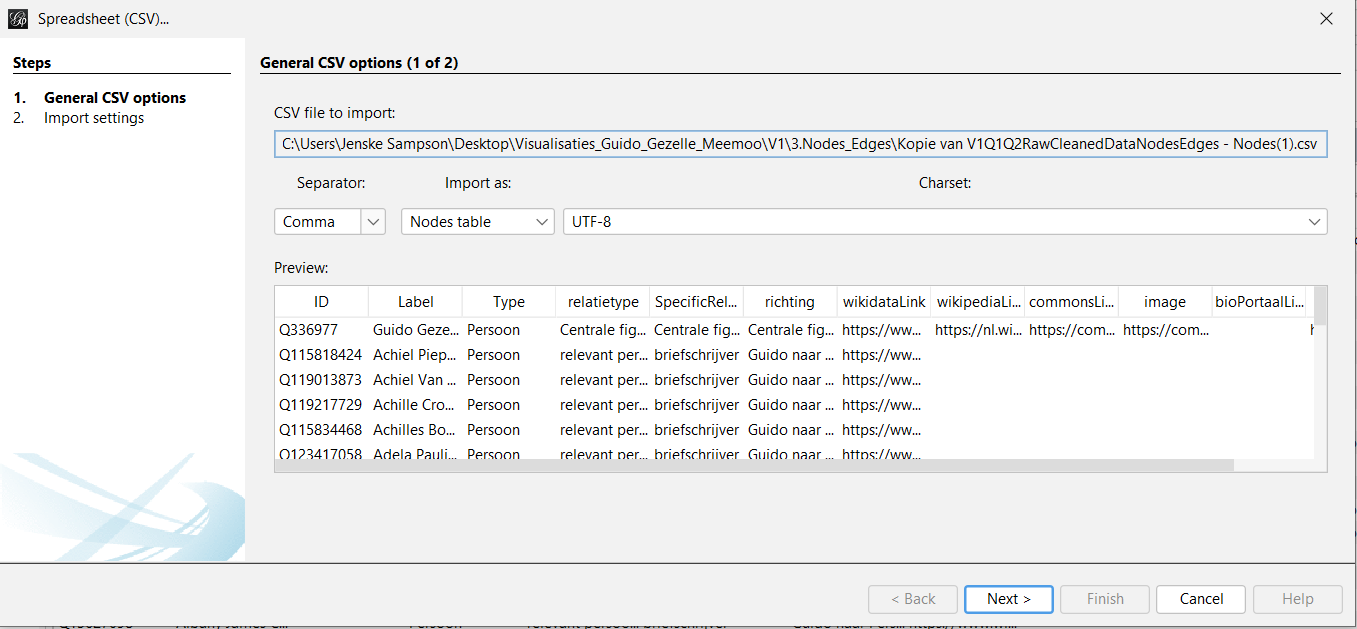

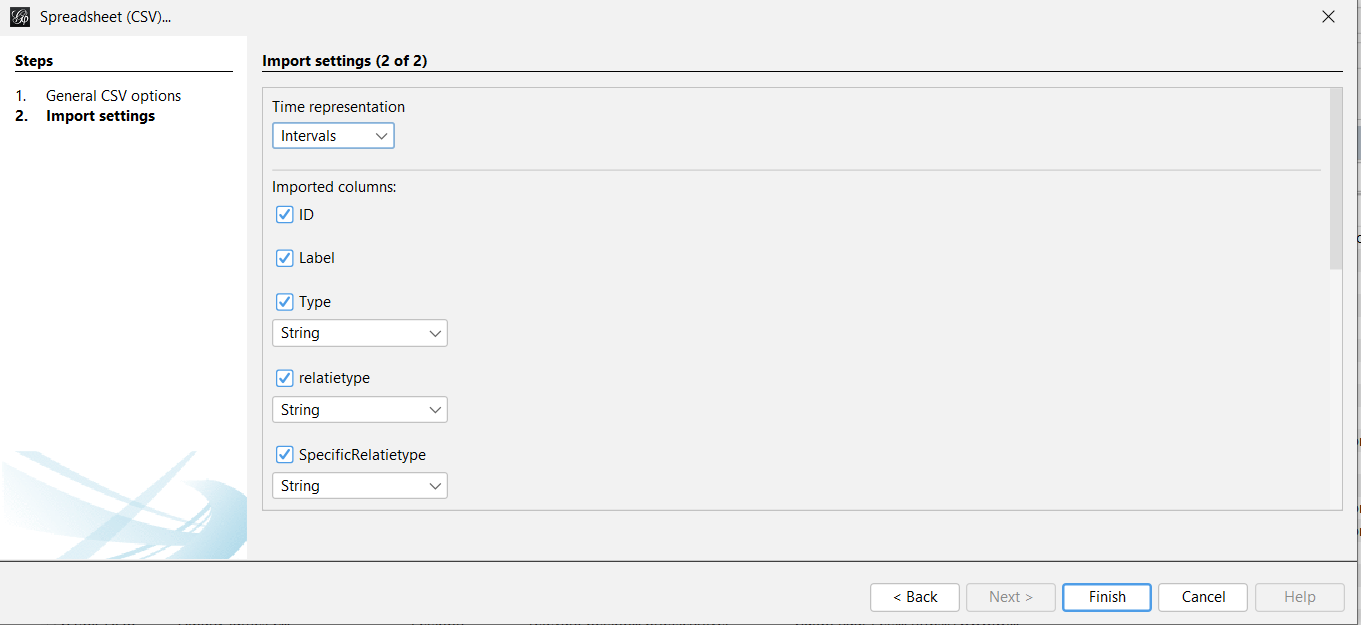


Nu beide bestanden zijn ingeladen, kan overgegaan worden op de layout van de graph. Ga in het hoofdmenu naar 'overview'. Je ziet nu volgende visualisatie:

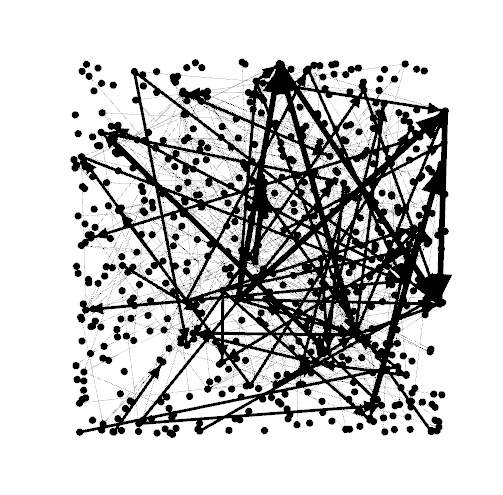

Opmerking: Soms krijg je bij het inladen fouten zoals dubbele nodes. In sommige gevallen konde we dit niet onmiddellijk verklaren of oplossen. Op zich kun je gewoon verder inladen en dit oplossen in Gephi zelf. Moesten er toch foutjes zijn in de visualisatie (bijvoorbeeld met grote pijlen/edges), dan kan je in ' data laboratory' naar de 'edge'-tab kijken naar het gewicht van de edges. Je kunt in dit geval alles selecteren door te slepen en met een rechterklik kiezen voor 'edit edges'. Links zul je een menu zien waar je de weight variabele kunt aanpassen. Hier kun je de waarde 1 ingeven voor alle edges. Op die manier zijn alle verbindingen even sterk en ziet de visualisatie er terug 'normaal' uit.

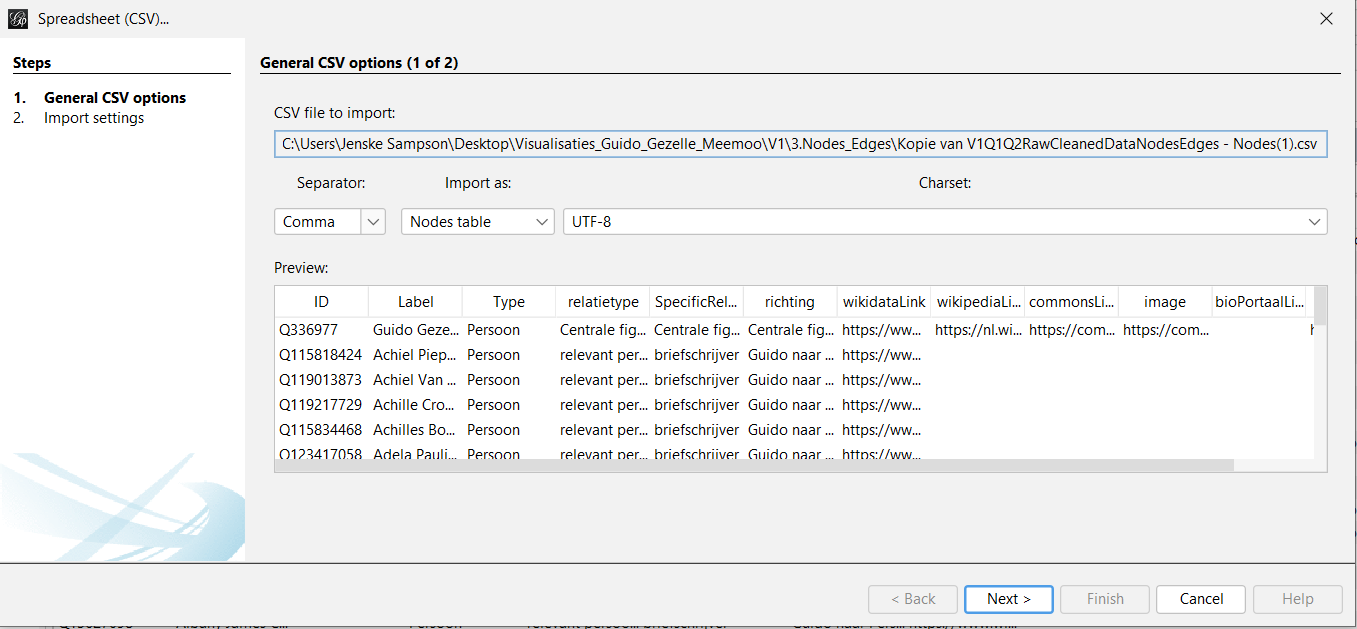

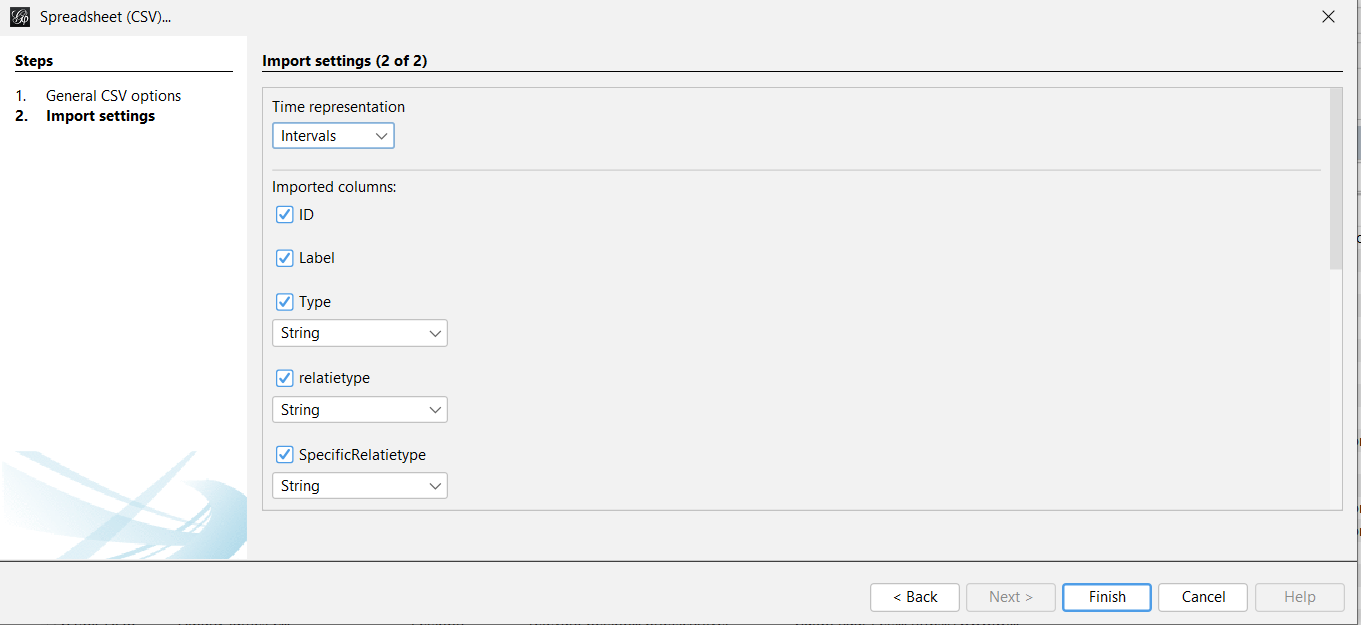


Nu beide bestanden zijn ingeladen,en gecheckt is op extra gewichten zie je volgend resultaat:  kan overgegaan worden op de layout van de graph. Ga in het hoofdmenu naar 'overview'. Je ziet nu volgende visualisatie:

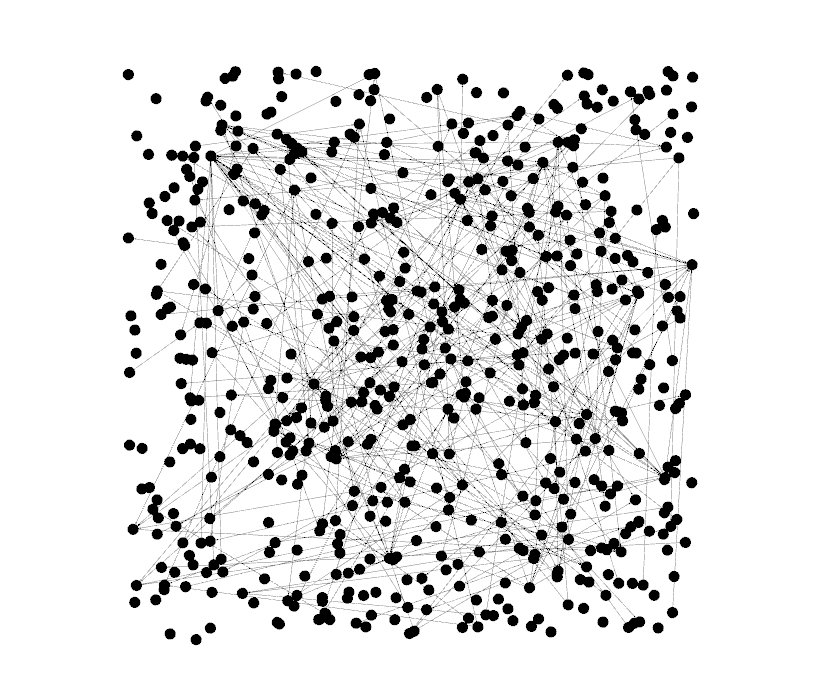

Vervolgens ordenen we de visualisatie. Om tot de gewenste vorm te komen, kun je links bij 'layout' kiezen uit een lijst sorteeralgoritmes.  Hier kiezen we voor ForceAtlas2. Kies dit en pas de 'scaling' aan naar waarde '55' en druk op 'Run'. Na enkele minuten kun je ook ordenen op 'no overlap'. Je krijgt nu onderstaande vorm:

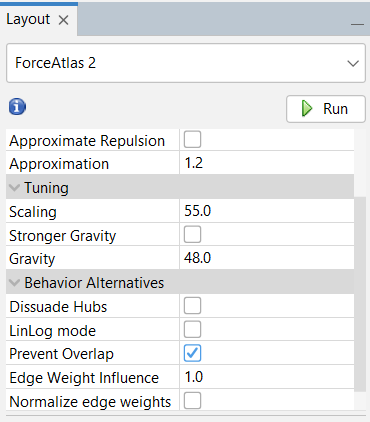

Je krijgt nu onderstaande vorm:

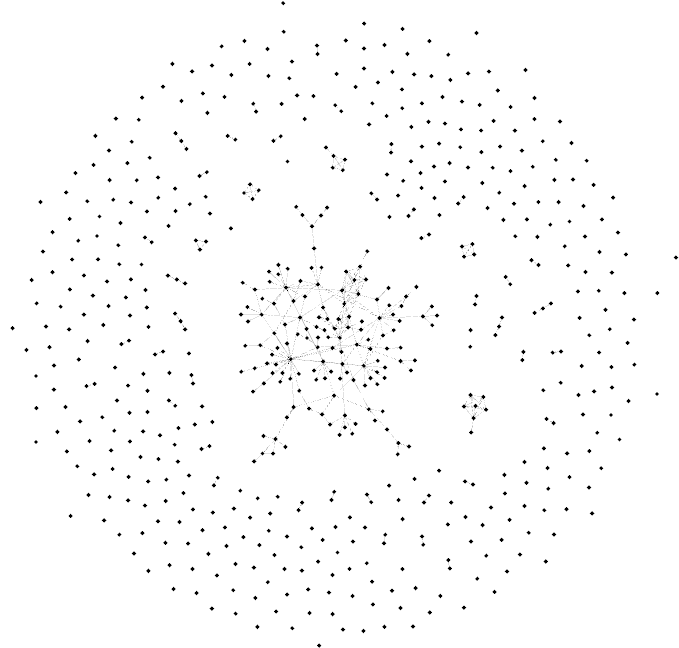

Vervolgens kunnen we ook de grootte en kleur van de knopen en verbindingen aanpassen om de visualisatie intuïtiever te maken.

De kleur van de knopen verwijst in dit geval naar gender. De grootte het aantal verbindingen met andere personen. Beiden kunnen aangepast worden in het 'appearance'-menu aan de linkerkant. Indien dit niet zichtbaar is, kan het in het hoofdmenu (boven) geselecteerd worden onder het tabblad 'windows'. Om gender aan te passen

De kleur van de verbindingen wijst op een familieband of correspondentieband. Ook dit kan geselecteerd worden in het 'appearance'-menu.

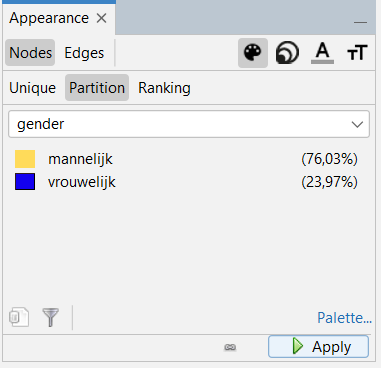

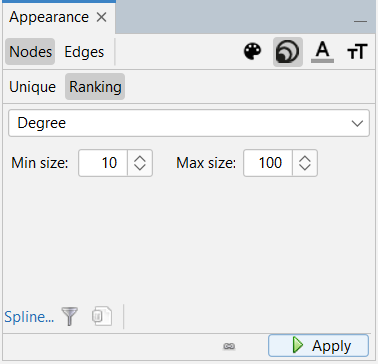

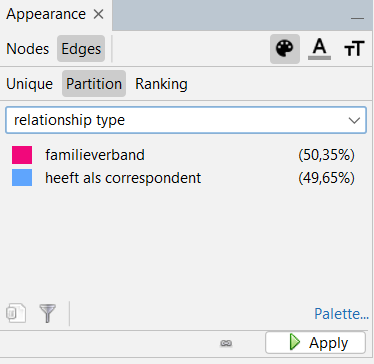

Je krijgt nu onderstaand resultaat:

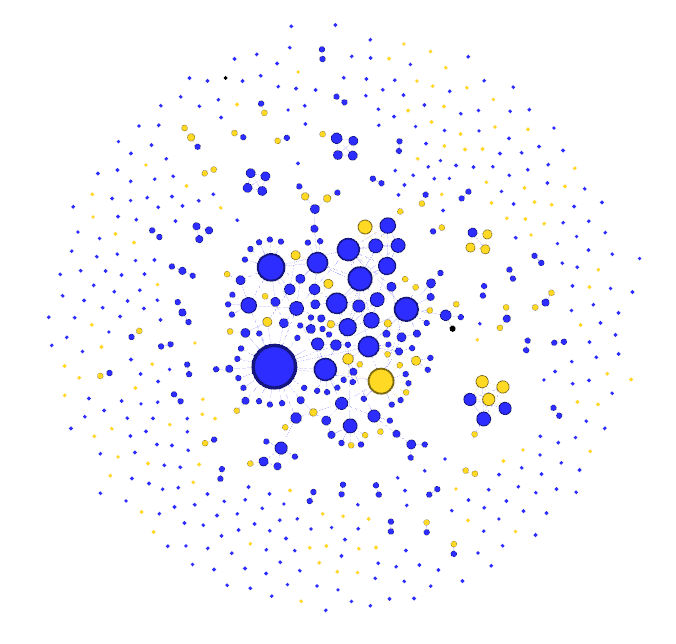

Tot slot kan het nog interessant zijn de verbindingen dikker te maken en de labels enkel zichtbaar te maken voor de geselecteerde knopen. De verbindingen kunnen dikker gemaakt worden in het preview scherm onder 'edges'- 'thickness'. Hier kan je de waarde verhogen. Een andere manier om de verbindingen en de pijlen dikker te maken is via het 'overview'-scherm. Hier kun je onder de visualisatie enkele tools vinden, bijvoorbeeld een grote witte letter 'T'. Door de balk te verschuiven, worden de lijnen dikker.


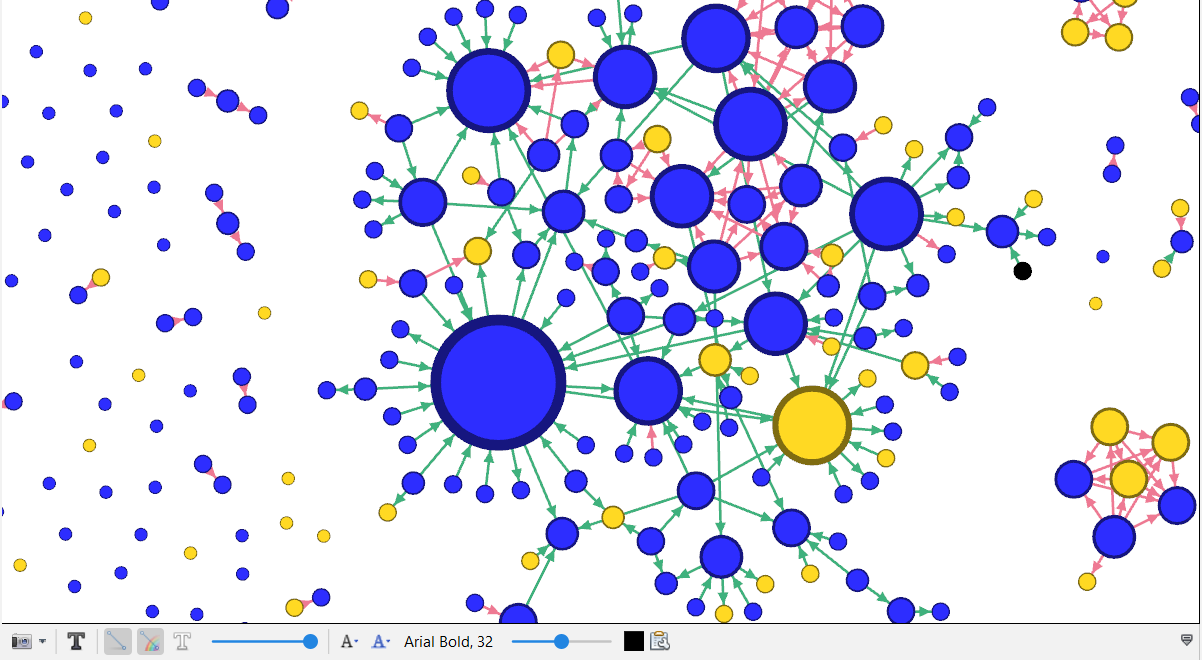

Tot slot kan ook het label zichtbaar gemaakt worden wanneer deze geselecteerd wordt. Alle labels op elk moment tonen wordt te onoverzichtelijk. Om dit te doen, drukken we op het symbooltje rechts onderaan ten opzichte van de visualisatie. Er opent dan een extra menu waar onder het tabblad 'labels' gekozen kan worden voor 'highlight selection'. Vervolgens vinken we links het vakje naast 'Node' aan, om de nodes bij selectie zichtbaar te maken (zie foto).

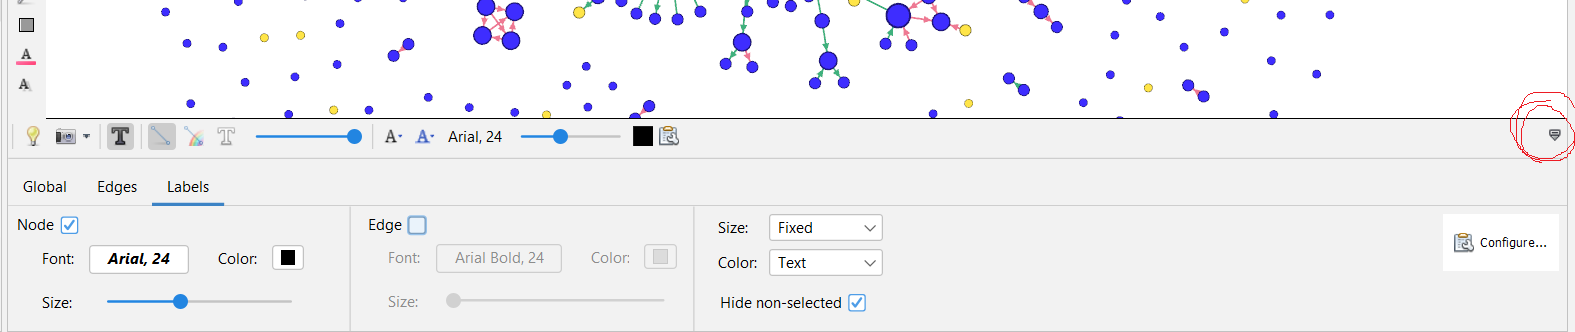

opmerkingen: in het 'preview'-blad van Gephi (naast Overview en Data laboratory) kunnen ook heel erg veel van deze en andere zaken aangepast worden in de visualisatie. Hier hebben we slechts enkele van de belangrijkste functies vanuit het 'overview'-menu voor deze visualisatie toegelicht.

**Importeren nieuw bestand met nodes of edges**

Als je later toch de data van de nodes of edges wil aanpassen in de originele spreadsheets, kun je de aangepaste versies eenvoudig opnieuw downloaden vanuit Excel of Google Spreadsheets en inladen via 'Data Laboratory'-'import spreadsheet' in Gephi. Je kan daarvoor eerst alle nodes of edges selecteren (ctrl+a) in Gephi en dan verwijderen. Vervolgens kun je de nieuwe set selecteren en inladen, zoals je deed na de opstart van Gephi.

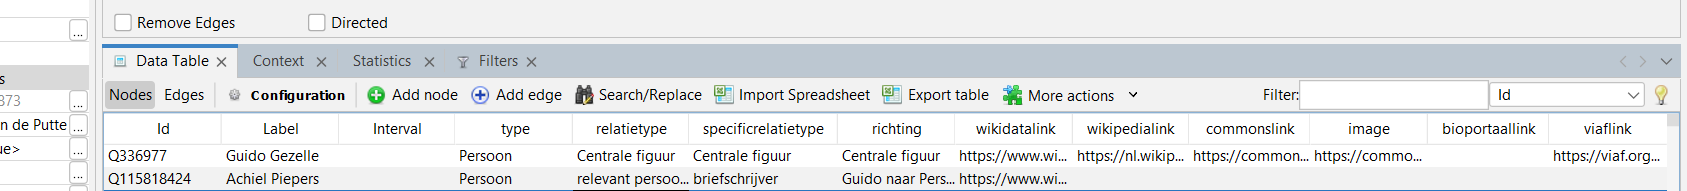

##EXPORTEREN MET SIGMA

Nu enkele aanpassingen zijn gebeurd qua layout via Gephi, zullen we de visualisatie exporteren en klaarmaken om op interactieve manier online te plaatsen. In dit geval zullen we gebruik maken van de plugin Sigma. Deze is geintegreerd in Gephi en kan op eenvoudige wijze geactiveerd en gebruikt worden. Andere plugins kunnen gebruikt worden, of indien je wat kunt programmeren is html en java ook een oplossing. In een van de andere visualisaties (zie andere hoofdstukken) maken we een plugin/interface met behulp van Gemini 3.0.

Hier tonen we hoe je de plugin installeert. Daarna tonen we enkele simpele zaken die je tijdens de export kunt instellen. De procedure is net zoals de Multimode Plugin.

Eerst ga je naar tools in het hoofdmenu (bovenaan), daarna klik je op plugin. In de interface zoek je naar Sigma Exporter. Je installeert die en drukt op 'active'. Eens geactiveerd, moet je Gephi herstarten om de plugin te laten werken. Na heropstart kan je je project exporteren.



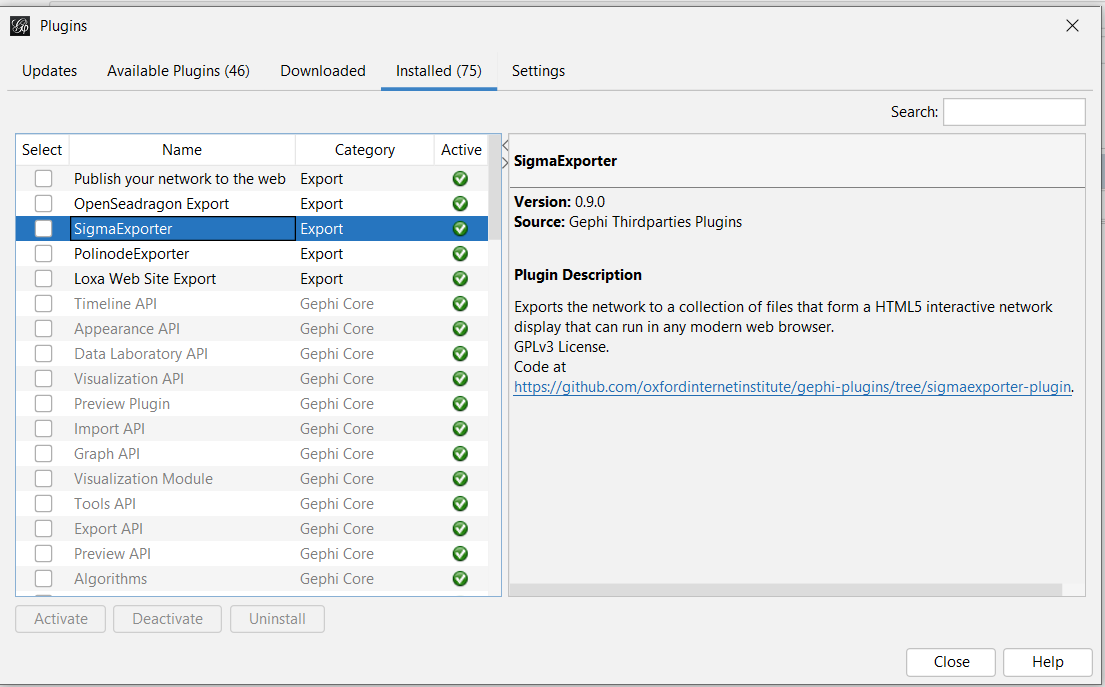

Om de visualisatie online te plaatsen op een interactieve manier, wordt er met een plugin gewerkt, in dit geval Sigma. Vanuit Gephi kan deze plugin gedownload en geactiveerd worden. We lichten toe wat we vervolgens hebben gedaan om deze klaar te maken.

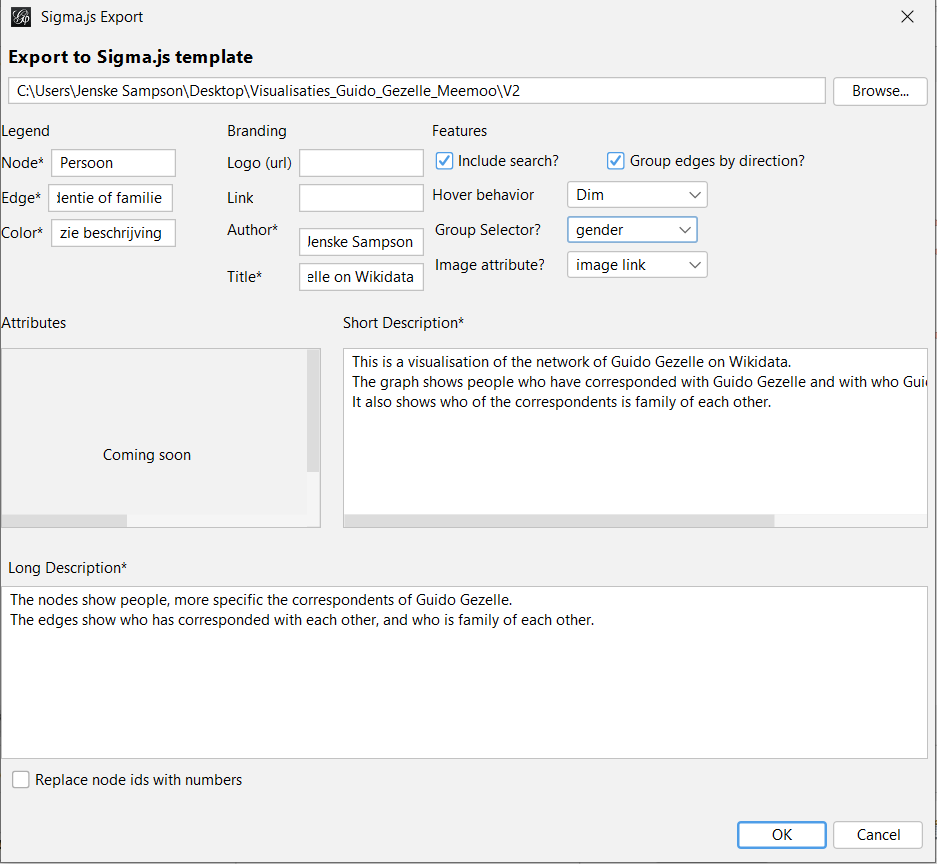

Er kan uitleg geplaatst worden bij de nodes en edges. Hier geven we aan dat node voor persoon staat. We geven ook aan dat een edge naar correspondentie of familie kan verwijzen. In de korte beschrijving kan meer uitleg geplaatst worden.Deze is beperkt door de ruimte die ze onmiddellijk inneemt op het scherm.

Er kan ook een uitvoerige uitleg bijgevoegd worden. Deze wordt zichtbaar in een popup-venster, waardoor de lengte veel meer kan zijn en niet in strijd komt met het zichtbare netwerk en de rest van de interface.

Sigma kan ook een foto linken en tonen per knoop. Hiervoor linken we de kolom imagelink aan 'image attribute'. Een interessante functie die ingesteld kan worden is de 'group selector'. Hier kan een indeling op basis van een attribuut gemaakt worden. In dit geval kiezen we voor het gender van de persoon, om een duidelijk overzicht van mannen en vrouwen te krijgen bij de correspondenten en familie.

Eens we de visualisatie opladen via Github, zal dit er zo uitzien:

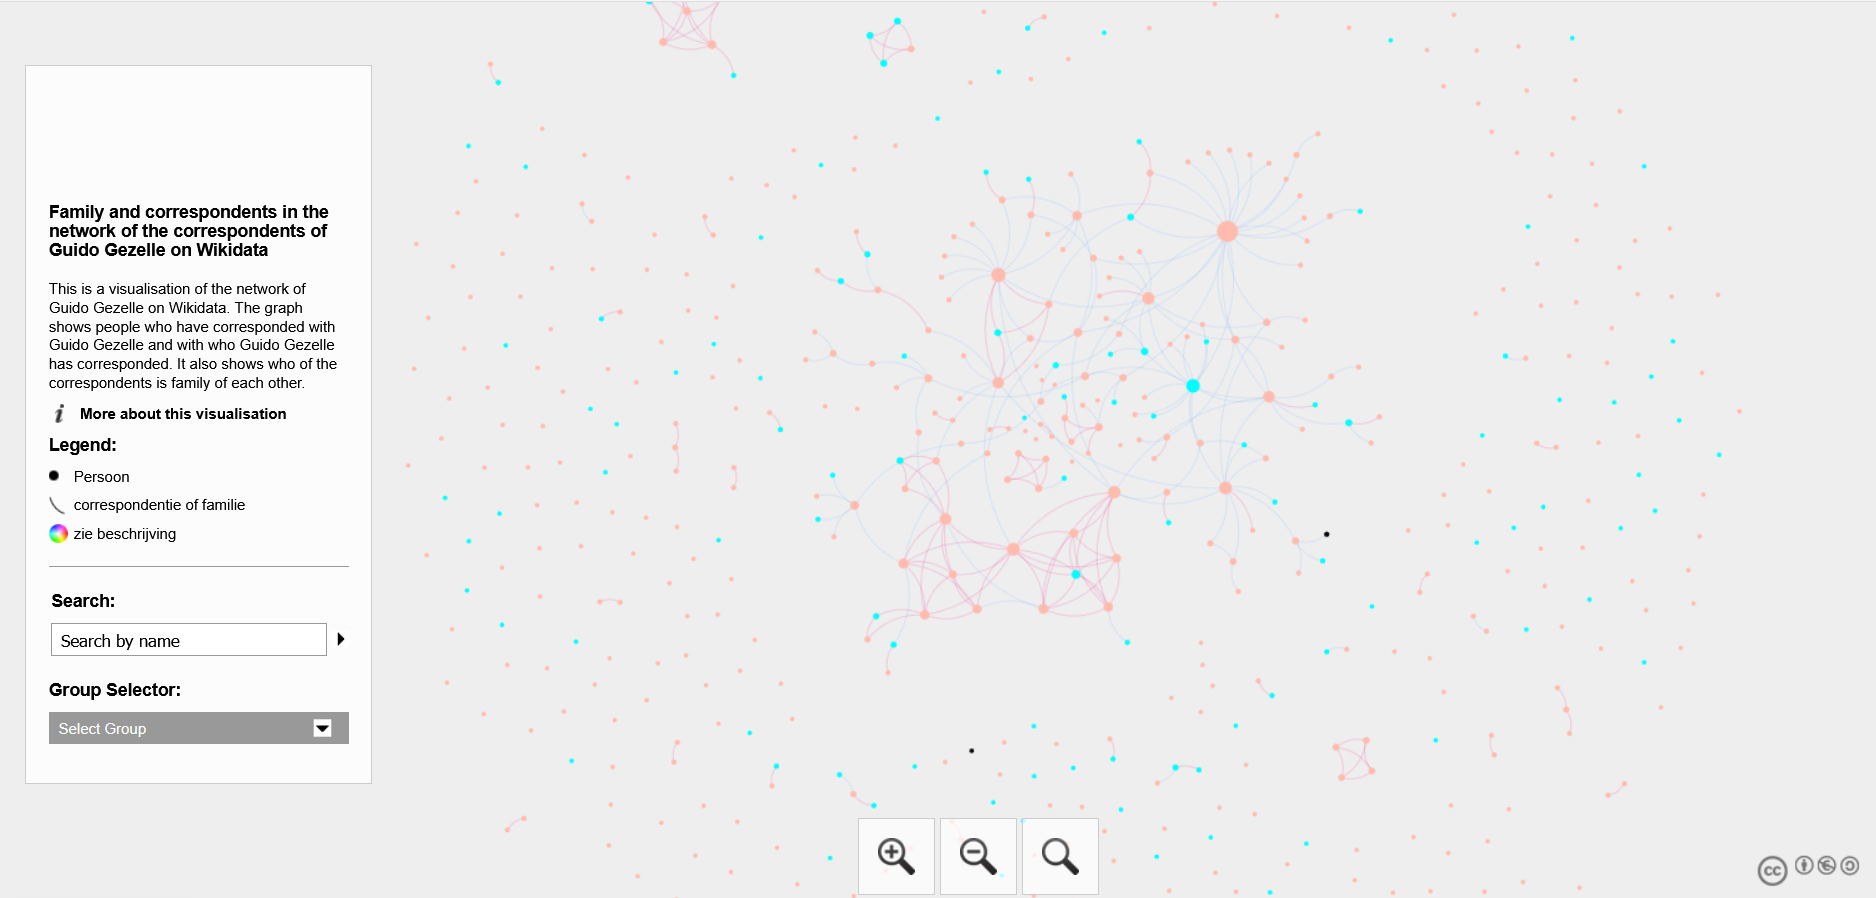

##GITHUB

Vervolgens willen we deze visualisatie interactief kunnen aanbieden op een website. Via github kunnen we deze documenten opladen en omzetten in een webpagina. Op zich is dit niet erg moeilijk eens men een account heeft op Github. Eerst en vooral moet er een repository gemaakt worden. Dit repository kan vervolgens omgezet worden tot een Github-page. Via de link naar de page krijg je de visualisatie te zien.

**repository**

Eerst en vooral maak je dus een nieuw repository aan op Github. Geef het een toepasselijke naam, bv 'VisualisatieGezelle1'. Vervolgens wordt de map met bestanden die werd klaargemaakt door Sigma hierin opgeladen.
Opmerking: het is belangrijk de inhoud van de map 'network' te kopiëren. De map 'network' zelf wordt niet mee gekopieerd. in dit geval zijn dit ongeveer 33 bestanden.

Klik op 'add files/upload new files'. Dit lukt mogelijk enkel in Chrome. Sommige browsers nemen niet alle bestanden over. Eens het opladen klaar is, kan je op 'commit' drukken. De bestanden zitten nu in het repository

**Github page**

Nu zullen we van het repository een webpagina maken. Daarvoor klikken we op het 'repository' en gaan vervolgens naar de 'settings'. Daar kiezen we voor 'pages'. Onder 'build and deployment' selecteer je 'main' als branch en in het vak ernaast voor 'root'. Klik vervolgens op 'save'. Wacht enkele minuten en herlaad de pagina. Je zult nu een link te zien krijgen waarop de webpagina te bekijken is:

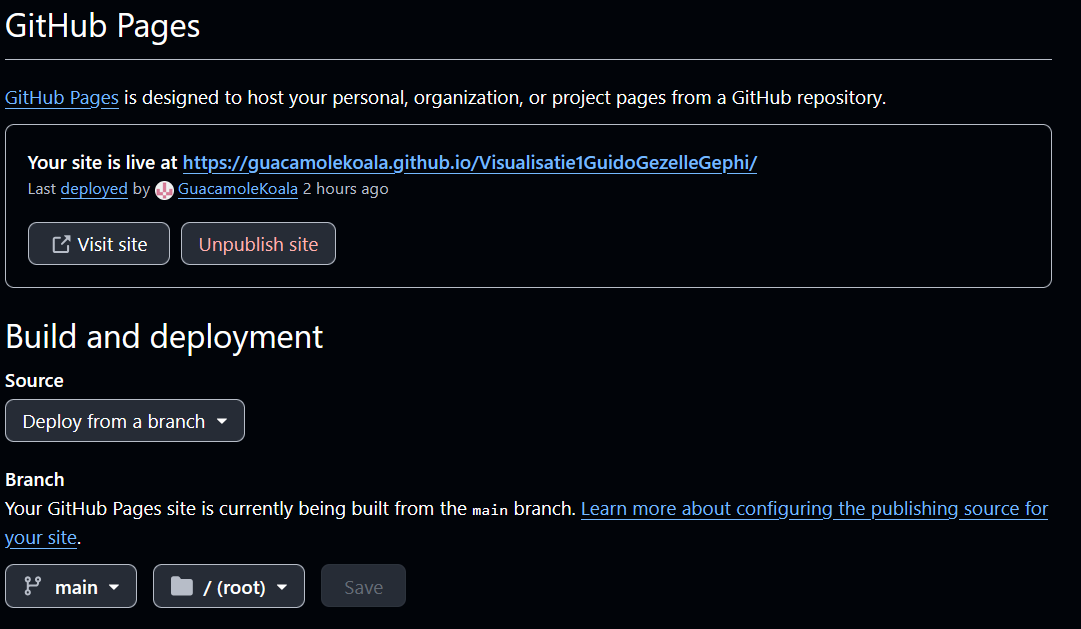

**Version control**

Je kan de code die opgeladen is, ook makkelijk aanpassen via het platform via Github. Op die manier kan je ook een controle/geschiedenis opbouwen aan veranderingen in je code. Op die manier kan je ook terugkeren naar een eerder moment, moest er iets fout lopen.

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

**Code aanpassen op Github:**



Je kan code van de bestanden gemakkelijk aanpassen via Github. Ga daarvoor naar de repository die je eerder hebt gemaakt en bekijk de bestanden door erop te klikken.

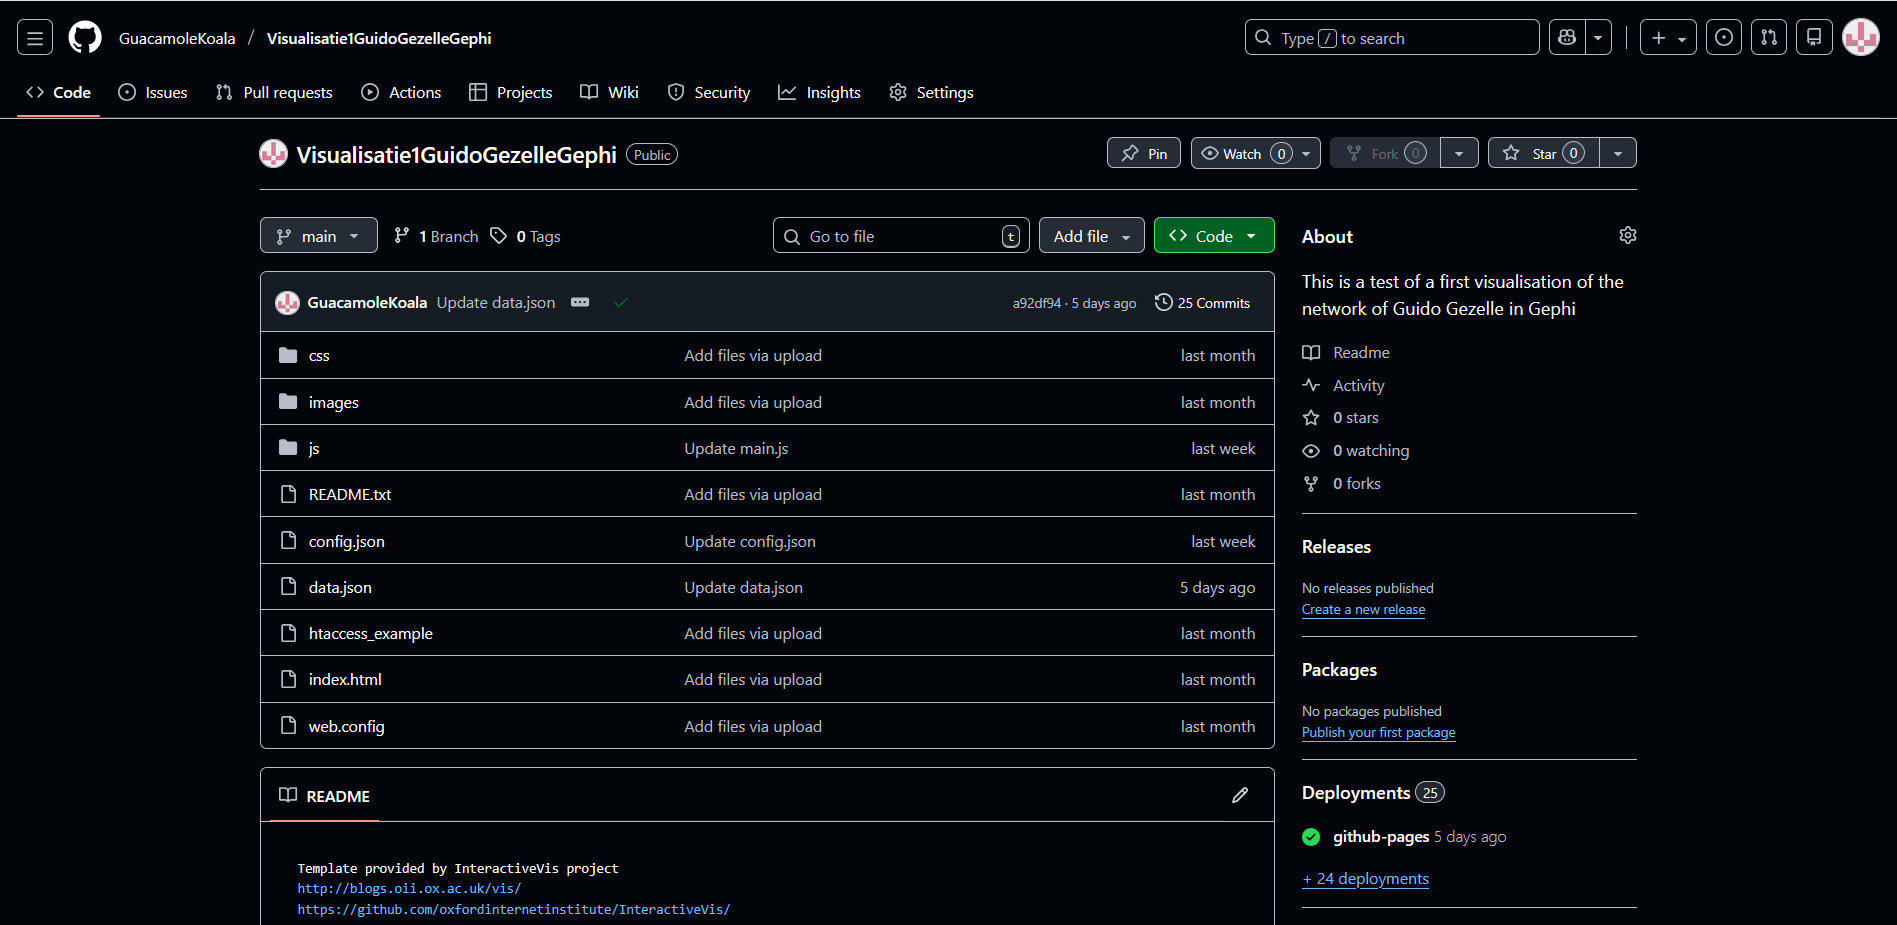

Als je rechts op het potlood-icoontje klikt, kun je de code direct aanpassen.

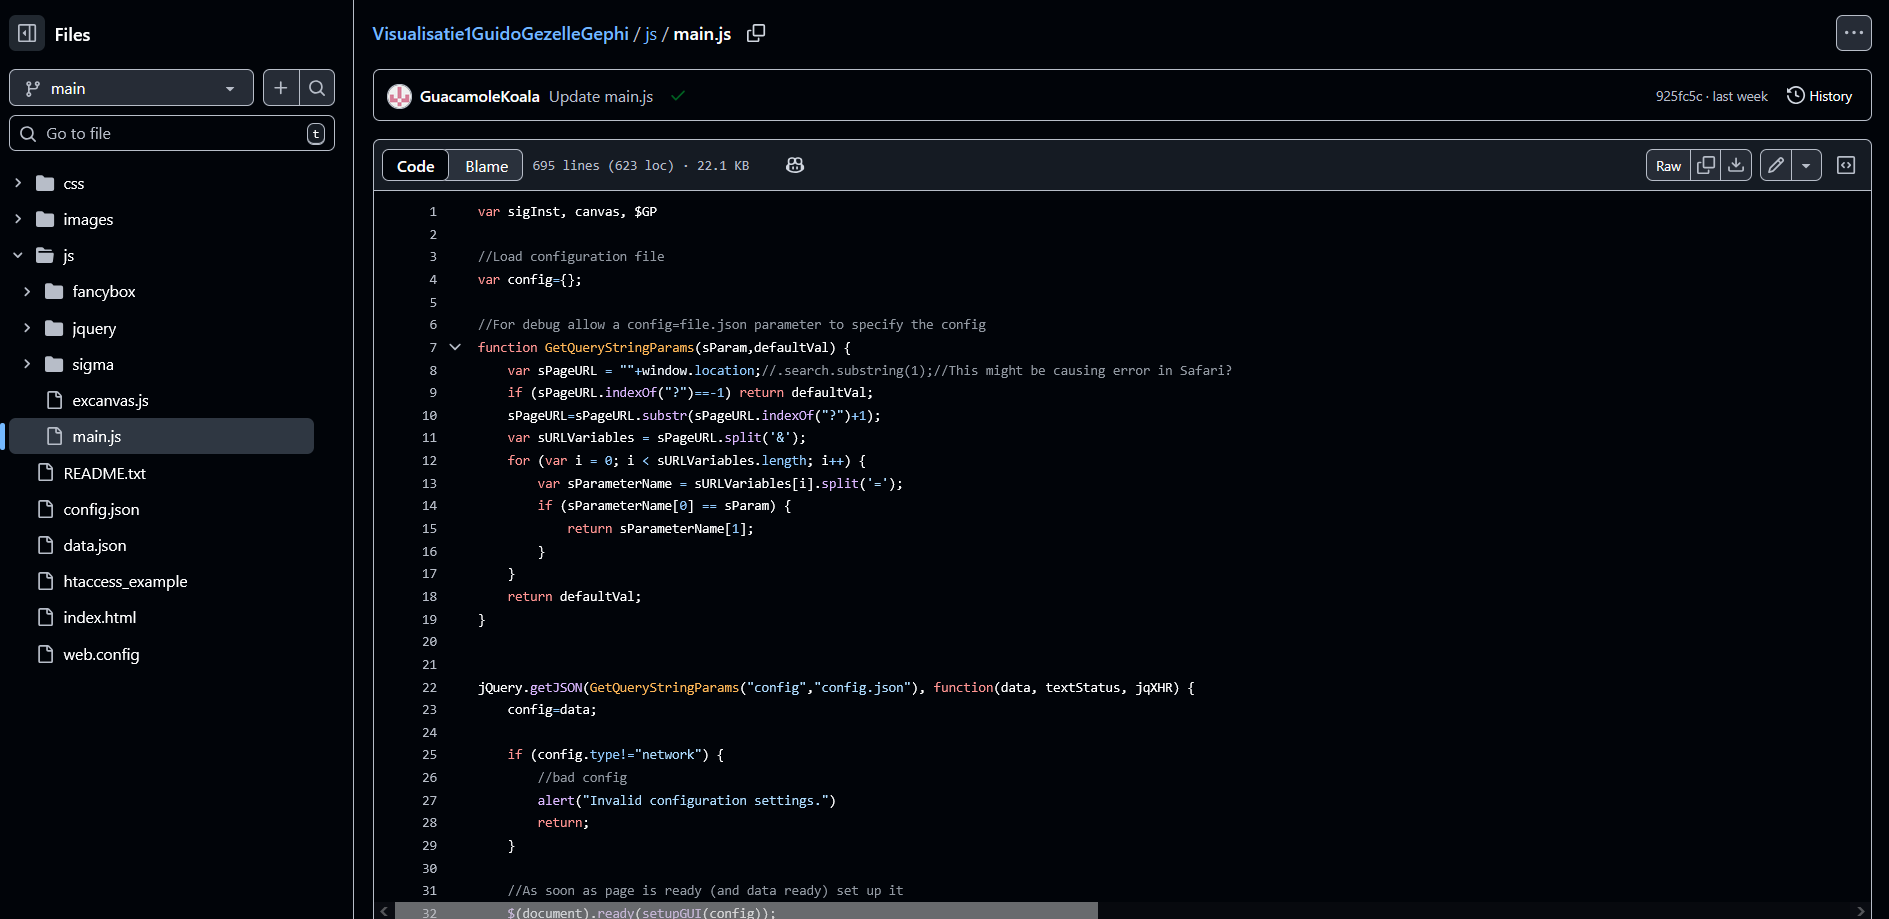

Na de aanpassingen druk je op 'commit changes'. Hier kun je ook een nota toevoegen van wat je precies hebt gedaan of verbeterd. Dit is belangrijk voor de controle van versies, indien er iets misgaat bijvoorbeeld.

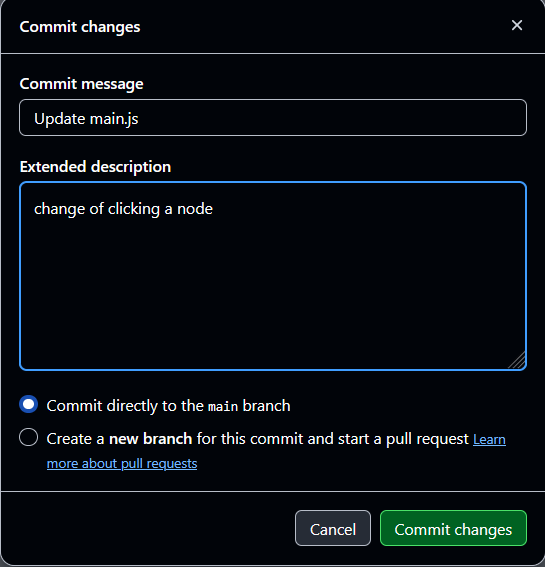

Na een paar minuten kun je de aanpassingen zien op de webpagina. Soms moet je opletten dat de browser niet een oude versie blijft herladen (door cache of cookies). Een optie is om even te wachten of in tussentijd een andere browser te proberen.

##AANPASSEN SCRIPT

Omdat de Sigma-interface nog niet optimaal was voor mijn visualisaties, zijn we aan de slag gegaan om de code van de interface wat aan te passen. Opmerking: bij deze stap hebben we uitvoerig gebruik gemaakt van generatieve AI, in het bijzonder Gemini 2.5. Via de juiste prompts kan Gemini helpen om de code aan te passen en gewenste resultaten te bereiken.


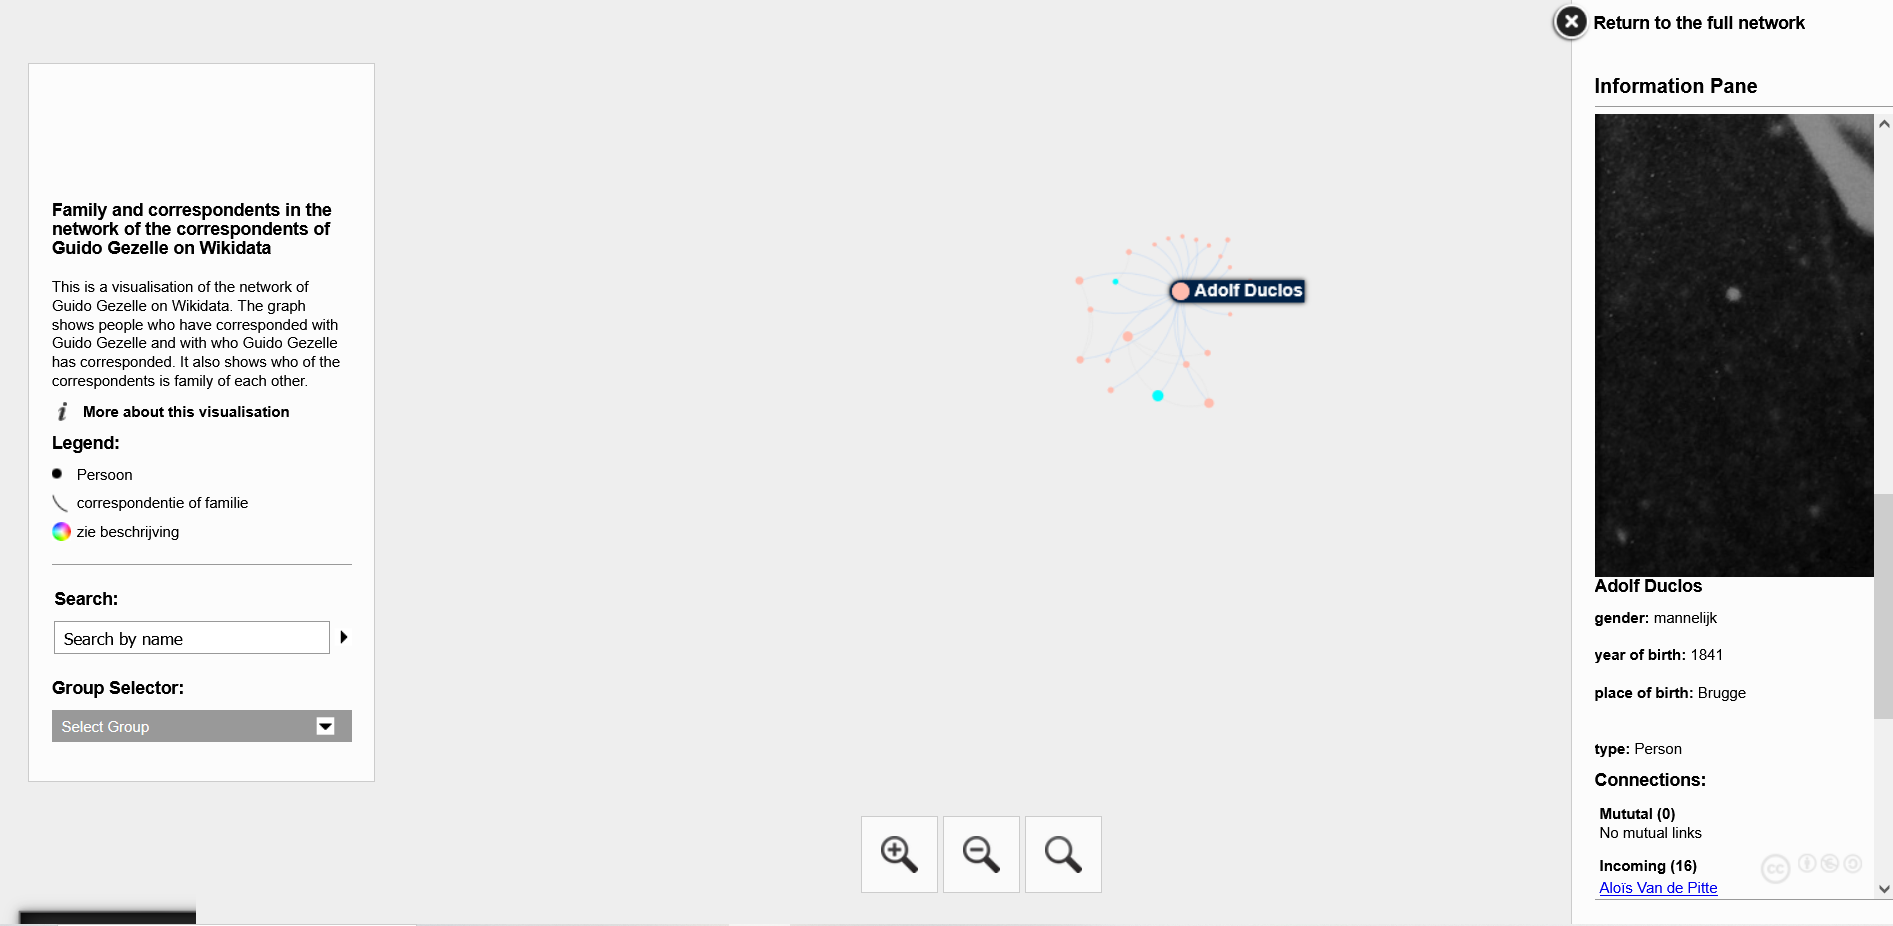

In de Sigma-export moeten enkele zaken aangepast worden in de files met de naam 'config.json', 'main.js' en index.html. Hieronder lichten we kort toe welke aanpassingen we hebben gedaan.

1) eerst en vooral willen we dat de visualisatie meer informatie toont als we op een knoop klikken. Daarvoor open momenteel een paneel aan de rechterkant. Hier willen we verschillende velden als attributen zien, in dit geval de link naar geboorteplaats, geboortejaar, gender en link naar afbeelding. Daarbij willen we eigenlijk ook dat ze in volgorde van 'type', 'gender', geboortejaar', 'geboorteplaats', en 'afbeelding' getoond worden.

2) De group selector in het linkerpaneel moet verbeterd worden. Momenteel toont die 'group 1', 'group 2', enzoverder, in plaats van de genders, namelijk 'man' of 'vrouw'.

3) In het infopaneel aan de rechtkant staat momenteel 'information pane'. We willen dit aanpassen naar 'information panel'. Daarnaast willen we na de export evt ook nog enkele tekstaanpassingen maken in de titel, beschrijving, enzovoort.

4) De foto's moeten kleiner getoond worden. Momenteel is dat heel groot en daardoor ook niet helemaal zichtbaar in het rechtpaneel na het klikken op een knoop.

5) De verbindingen (edges) mogen dikker zijn, zodat ze beter zichtbaar worden. Momenteel zijn ze heel erg dun, ook bij het inzoomen.


**1. Meer informatie bij knopen**: Om deze aanpassingen door te voeren moeten we kijken naar onderstaande code in het main.js-bestand. Deze code werd geschreven met Gemini. We hebben hier enkele kleine zaken in aangepast, die niet zo belangrijk zijn. Je kan simpelweg op zoek gaan naar de code en ze proberen te vervangen. Als dit niet onmiddellijk lukt, kan je ook de onderstaande code voeden aan Gemini en vragen samen een oplossing te bedenken om het te integreren in jouw voorbeeld.

Oude code:

```
   f = b.attr;
    if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}
        e = [];
        temp_array = [];
        g = 0;
        for (var attr in f.attributes) {
            var d = f.attributes[attr],
                h = "";
			if (attr!=image_attribute) {
                h = '<span><strong>' + attr + ':</strong> ' + d + '</span><br/>'
			}
            //temp_array.push(f.attributes[g].attr);
            e.push(h)
        }

        if (image_attribute) {
        	//image_index = jQuery.inArray(image_attribute, temp_array);
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        // Image field for attribute pane
        $GP.info_data.html(e.join("<br/>"))
    }
    $GP.info_data.show();
    $GP.info_p.html("Connections:");
    $GP.info.animate({width:'show'},350);
	$GP.info_donnees.hide();
	$GP.info_donnees.show();
    sigInst.active = a;
    window.location.hash = b.label;
}
```

te vervangen met nieuwe code:

```
 // UPDATED: Specific Information Panel Display
    if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}
        e = [];
        
        // Manually define the order of attributes to show
        var attributesToShow = [
            { key: 'type', label: 'Type' },
            { key: 'gender', label: 'Gender' },
            { key: 'year of birth', label: 'Year of Birth' },
            { key: 'place of birth', label: 'Place of Birth' },
            { key: 'image link', label: 'Image link' }
        ];

        for (var i = 0; i < attributesToShow.length; i++) {
            var key = attributesToShow[i].key;
            var label = attributesToShow[i].label;
            // check if attribute exists in the node data
            if (f.attributes[key]) {
                e.push('<span><strong>' + label + ':</strong> ' + f.attributes[key] + '</span><br/>');
            }
        }

        if (image_attribute && f.attributes[image_attribute]) {
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        // Image field for attribute pane
        $GP.info_data.html(e.join(""))
    }
    $GP.info_data.show();
    $GP.info_p.html("Connections:");
    $GP.info.animate({width:'show'},350);
	$GP.info_donnees.hide();
	$GP.info_donnees.show();
    sigInst.active = a;
    window.location.hash = b.label;
}
```

**2. Aanpassen van de groepenselector**: Om de groepen van de selector te linken aan een specifiek attribuut, in dit geval de gender, moet de code aangepast worden. Hier is de volledige uitschrijving van de drie codeblokken die de verbetering in de groepsselector (a.clusters en a.clusterNames) uitmaken, met de focus op de functies initSigma en configSigmaElements.

A. Dataverzameling in initSigma

Dit blok toont hoe de nieuwe code een extra object (a.clusterNames) gebruikt om de specifieke groepsnaam (afkomstig van een attribuut in de data) te koppelen aan de kleur van de groep. De oude code gebruikte alleen de kleur voor het clusteren.

Oude Code:

JavaScript

```
// Oude versie: Dataverzameling in initSigma

    dataReady = function() {//This is called as soon as data is loaded
        a.clusters = {};

        a.iterNodes(
            function (b) { //This is where we populate the array used for the group select box

                // ...
                a.clusters[b.color] || (a.clusters[b.color] = []);
                a.clusters[b.color].push(b.id);//SAH: push id not label
            }
        
        );
    // ...
    }
```

Nieuwe Code waardoor de oude kan vervangen worden:

JavaScript

```
// Nieuwe versie: Dataverzameling in initSigma (met clusterNames)

    dataReady = function() {//This is called as soon as data is loaded
        a.clusters = {};
        **a.clusterNames = {}; // NEW: object to map color to the group attribute name**
        
        **var groupAttrKey = config.features.groupSelectorAttribute; // e.g., "Gender"**

        a.iterNodes(
            function (b) { //This is where we populate the array used for the group select box

                // ...
                a.clusters[b.color] || (a.clusters[b.color] = []);
                a.clusters[b.color].push(b.id);//SAH: push id not label

                **// NEW: Populate clusterNames with the group name for display**
                **var groupName = b.attr.attributes[groupAttrKey];**
                **if (groupName) {**
                    **a.clusterNames[b.color] = groupName; // Map color to group name**
                **}**
            }
        
        );
    // ...
    }
```



B. UI Constructie in configSigmaElements

Dit blok toont hoe de verzamelde groepsnamen worden gebruikt om de lijst in de groepsselector (aan de rechterkant van het scherm) te construeren.

Oude Code:

JavaScript


```
// Oude versie: UI Constructie in configSigmaElements

    $GP.bg = $(sigInst._core.domElements.bg);
    $GP.bg2 = $(sigInst._core.domElements.bg2);
    var a = [],
        b,x=1;
        for (b in sigInst.clusters) a.push('<div style="line-height:12px"><a href="#' + b + '"><div style="width:40px;height:12px;border:1px solid #fff;background:' + b + ';display:inline-block"></div> **Group ' + (x++) + '** (' + sigInst.clusters[b].length + ' members)</a></div>');
    //a.sort();
    $GP.cluster.content(a.join(""));
    // ...

```

Nieuwe Code:

JavaScript

```
// Nieuwe versie: UI Constructie in configSigmaElements (met clusterNames)

    $GP.bg = $(sigInst._core.domElements.bg);
    $GP.bg2 = $(sigInst._core.domElements.bg2);
    var a = [],
        b,x=1;
        **// MODIFIED: Use sigInst.clusterNames to display the group attribute name**
        for (b in sigInst.clusters) {
            **var groupName = sigInst.clusterNames[b] \|\| 'Group ' + (x++);**
            a.push('<div style="line-height:12px"><a href="#' + b + '"><div style="width:40px;height:12px;border:1px solid #fff;background:' + b + ';display:inline-block"></div> ' + **groupName** + ' (' + sigInst.clusters[b].length + ' members)</a></div>');
        }
    //a.sort();
    $GP.cluster.content(a.join(""));
    // ...
```


C. Groepsheader in showCluster

Dit blok toont hoe de titel van het informatiepaneel wordt aangepast wanneer een groep wordt geselecteerd, zodat de werkelijke groepsnaam wordt weergegeven in plaats van alleen de kleur of een standaardtekst.

Oude Code:

JavaScript

```
// Oude versie: Groepsheader in showCluster

    // ...
        sigInst.draw(2, 2, 2, 2);
        $GP.info_name.html("<b>" + a + "</b>"); // Toont alleen de hex-kleurcode of de hash
        $GP.info_data.hide();
        $GP.info_p.html("Group Members:");
    // ...

```

Nieuwe Code:

JavaScript


```
// Nieuwe versie: Groepsheader in showCluster (met clusterNames)

    // ...
        sigInst.draw(2, 2, 2, 2);
        **// MODIFIED: Use the mapped name in the cluster header**
        $GP.info_name.html("<b>" + **(sigInst.clusterNames[a] \|\| a)** + "</b>");
        $GP.info_data.hide();
        $GP.info_p.html("Group Members:");
    // ...
```



**3. Typfout in 'information panel'**: het probleem in verband met de typfout in 'information pane' is simpel op te lossen door in de index.html te zoeken naar 'information pane' en deze simpelweg aan te passen naar 'information panel'. Vervolgens kun je het bestanden opnieuw opladen.

**4. Grootte van een afbeelding aan te passen**: ook hier werd hulp gevraagd aan Gemini. De grootte van de afbeelding wordt bepaald door de HTML-styling binnen de nodeActive functie in mainadj.js. We kunnen dit aanpassen door een vaste maximale hoogte of breedte in te stellen op de <img> tag. Hier is de aangepaste code die een maximale hoogte van 60 pixels instelt voor de afbeelding, waardoor deze als een thumbnail wordt weergegeven.

Zoek de regel in de sectie waar image_attribute waar is (if (image_attribute)) in mainadj.js:

JavaScript
```
// OUDE CODE (in mainadj.js - binnen if (image_attribute))
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

Nieuwe Code (met vaste afmeting)

Vervang de style attribuutwaarde om een maximale hoogte in te stellen (bijvoorbeeld max-height:60px en max-width:60px om een duidelijke thumbnail te krijgen):

JavaScript:
```
// NIEUWE CODE (vervangende regel in mainadj.js)
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

**5. aanpassen dikte verbindingen**: Het vijfde vraagstuk is eenvoudig op te lossen door naar config.json te gaan en volgende waarden aan te passen. In dit geval hebben we de waarden van de knopen (nodes) en verbindingen (edges) verhoogd.

```
"maxEdgeSize": 0.8,
"minEdgeSize": 0.8,
"minNodeSize": 2,
"maxNodeSize": 10
```

Na al deze aanpassingen, krijgen we volgend resultaat te zien op de webpagina na het aanklikken van een knoop:

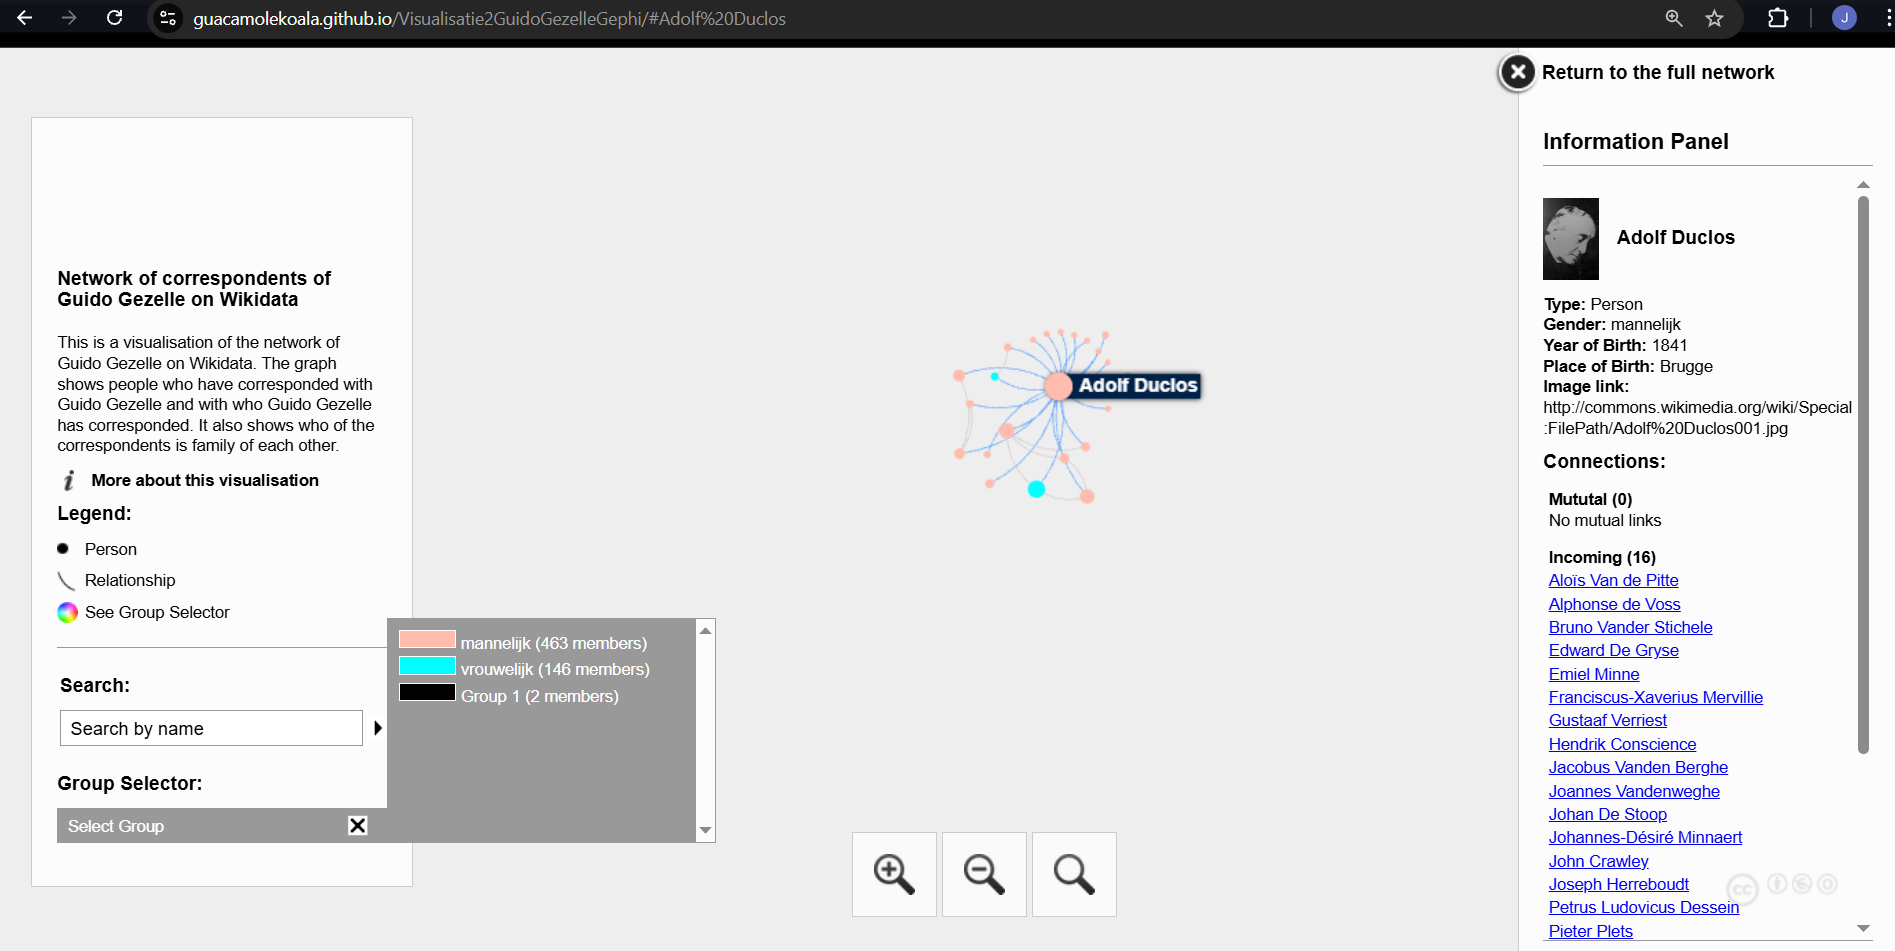

##FINAAL RESULTAAT

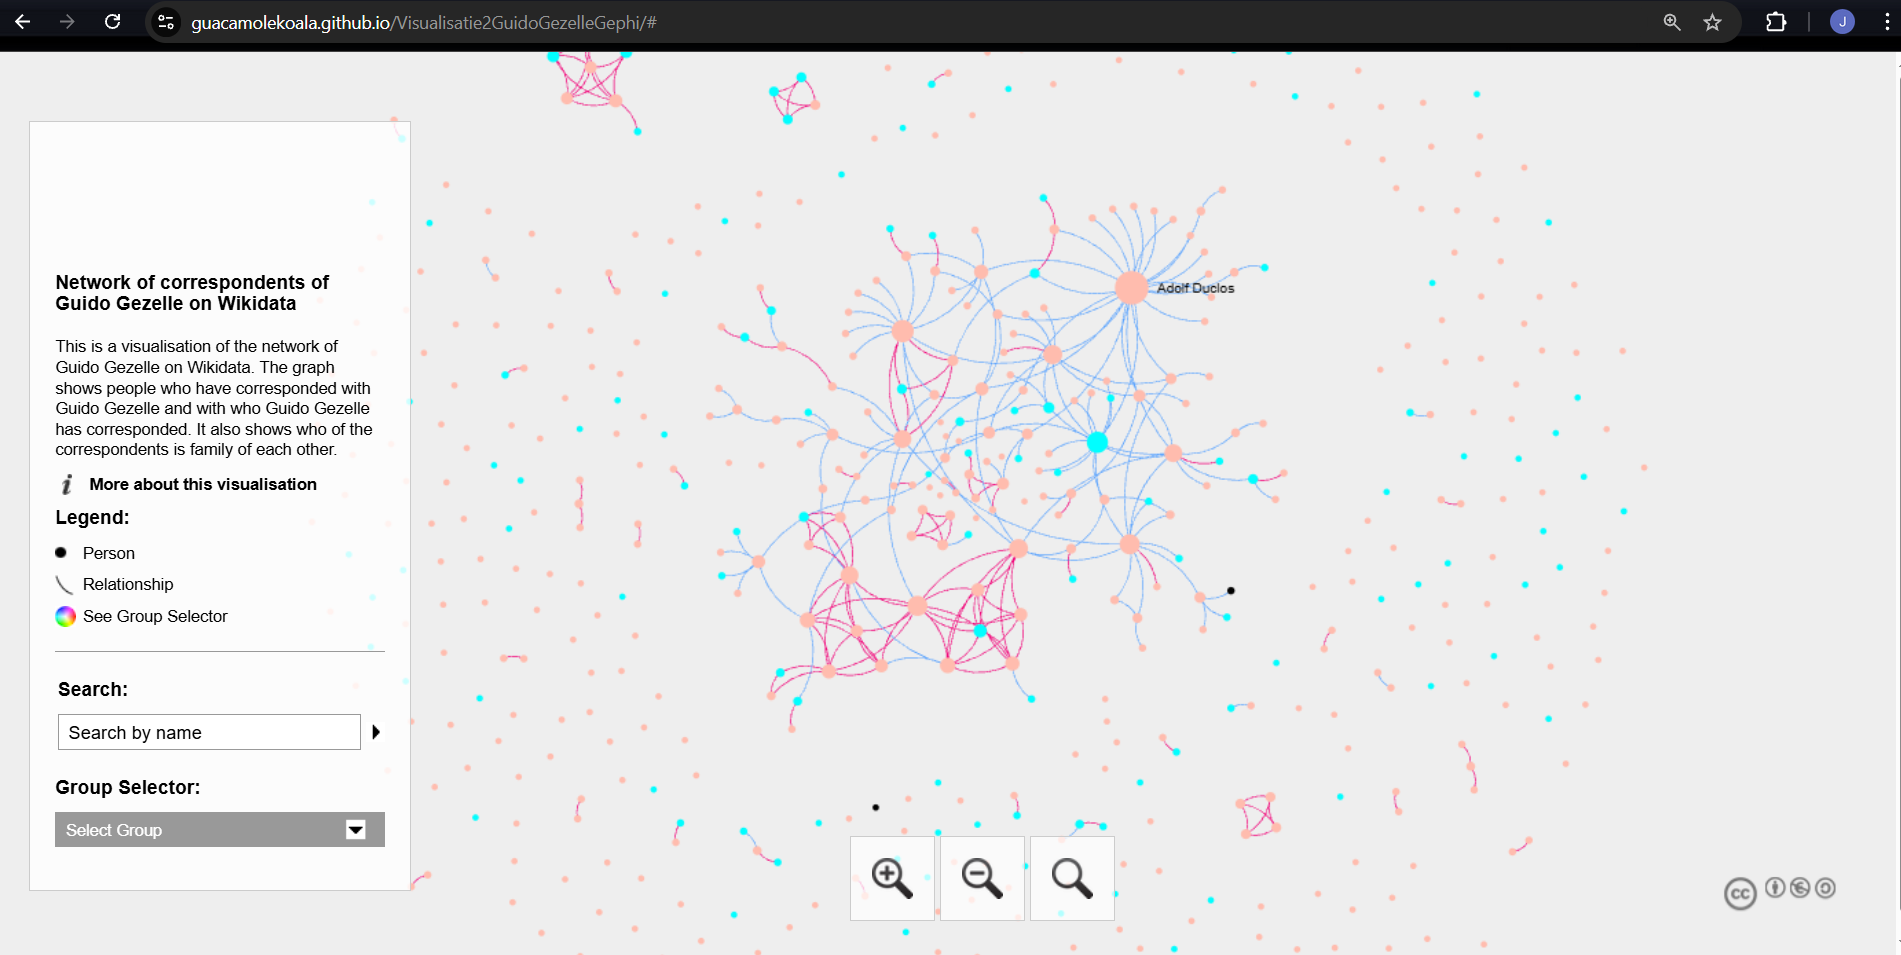

https://guacamolekoala.github.io/Visualisatie2GuidoGezelleGephi

In deze handleiding werd een visualisatie gemaakt op basis van beschikbare data omtrent Guido Gezelle.
Eerst werden enkele queries ontworpen. Daarna werden deze via Spreadsheets omgezet naar een knopenbestand en een verbindingenbestand. Daarna werd getoond hoe deze bestanden opgeladen worden in Gephi en er een visualisatie van gemaakt wordt. Er werd stilgestaa6n bij de layout, alsook bij de export via Sigma. In een laatste fase werd de interactieve visualisatie online beschikbaar gemaakt als Github-webpagina. Met behulp van generatieve AI, in dit geval Gemini, werd de code aangepast om wat meer functionaliteit toe te voegen.